# IMDB Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RNN
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
SEED = 2018
VOCAB_SIZE = 100
MAX_REVIEW_LEN = 250
NUM_EPOCHS = 5
BATCH_SIZE = 64

In [3]:
def get_x_y(file_path):
    files = {}
    files['pos'] = glob(os.path.join(file_path, 'pos', '*.txt'))
    files['neg'] = glob(os.path.join(file_path, 'neg', '*.txt'))
    
    sentiment_map = {'pos': 1, 'neg': 0}
    x = []
    y = []
    for sentiment in files:
        for file_name in files[sentiment]:
            temp_ = []
            with open(file_name) as file_:
                temp_ = file_.read()
            x.append(temp_)
            y.append(sentiment_map[sentiment])
    return x, y

In [4]:
# Read in the text data
x_train_raw, y_train_raw = get_x_y(TRAIN_PATH)
x_test_raw, y_test_raw = get_x_y(TEST_PATH)

In [5]:
print(x_train_raw[0])
print(y_train_raw[0])

Not the most successful television project John Cleese ever did, "Strange Case" has the feel of a first draft that was rushed into production before any revisions could be made. There are some silly ideas throughout and even a few clever ones, but the story as a whole unfortunately doesn't add up to much.<br /><br />Arthur Lowe is a hoot, though, as Dr. Watson, bionic bits and all. "Good Lord."
1


In [6]:
review_lengths = []
for review in x_train_raw:
    review_lengths.append(len(review.split(' ')))

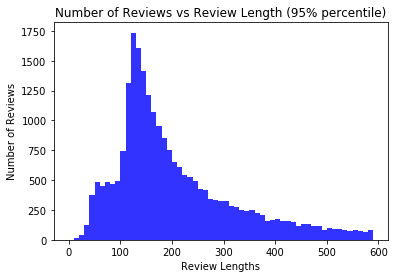

In [7]:
percent_95 = np.percentile(review_lengths, 95)
bins = np.arange(0, percent_95, 10)
plt.hist(review_lengths,bins,color='blue',alpha=0.8)
plt.xlabel('Review Lengths')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews vs Review Length (95% percentile)')
plt.show()

While this type of data makes sense to humans, we need to convert the (in this case) English sentences into sequences of numbers. This can be done by using a tool provided by Keras called a 'Tokenizer'. This transforms strings into sequences of numbers where words are mapped to numbers corresponding to their overall frequency. For example, if the word 'a' is the most common word and 'this' is the second most common the sentence: 'This is a dog.' Would become [2, 0, 1, 0], where '0' is a placeholder for any word not in the tokenizer. We also need to make sure all of our sequences are the same length. we can choose a length that makes sense and pad the sequences with zeros to that length.

Note: We have already did some transformations by converting 'pos' => 0, and 'neg' => 1 when we read in the data

In [8]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train_raw)

In [9]:
# Fit our training data
x_train = tokenizer.texts_to_sequences(x_train_raw)
x_train = pad_sequences(x_train, maxlen=MAX_REVIEW_LEN)

# Fit our testing data
x_test = tokenizer.texts_to_sequences(x_test_raw)
x_test = pad_sequences(x_test, maxlen=MAX_REVIEW_LEN)

In [10]:
print(x_train[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21  1 88
 44  1  4  3 83 12 13 80 98 97 27 90 47 23 46  2 57  3 18  1 62 14  3 53
  5 73  7  7  6  3 14  2 29 49]


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [13]:
model = SGDClassifier()
model.fit(x_train, y_train_raw)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test_raw, pred)
print(accuracy)

0.50584


/home/mike/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [14]:
def basic_lstm_model(embedding_vector_length=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, embedding_vector_length, input_length=MAX_REVIEW_LEN))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(100))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
model = basic_lstm_model()
model.fit(x_train, y_train_raw, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
scores = model.evaluate(x_test, y_test_raw, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
25000/25000 [==============================] - 120s 5ms/step - loss: 0.6213 - acc: 0.6565
Epoch 2/5
25000/25000 [==============================] - 119s 5ms/step - loss: 0.5566 - acc: 0.7178
Epoch 3/5
25000/25000 [==============================] - 118s 5ms/step - loss: 0.5409 - acc: 0.7316
Epoch 4/5
25000/25000 [==============================] - 117s 5ms/step - loss: 0.5374 - acc: 0.7330
Epoch 5/5
25000/25000 [==============================] - 117s 5ms/step - loss: 0.5355 - acc: 0.7325
Accuracy: 73.09%


In [16]:
VOCAB_SIZE = 100
MAX_REVIEW_LEN = 250
NUM_EPOCHS = 1
BATCH_SIZE = 64
EMBED_LENGTH = 32
DROPOUT_RATE = 0.2

In [17]:
time_start = datetime.now()

# Read in the text data
x_train, y_train = get_x_y(TRAIN_PATH)
x_test, y_test = get_x_y(TEST_PATH)

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Fit our training data
x_train_sequence = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_sequence, maxlen=MAX_REVIEW_LEN)

# Fit our testing data
x_test_sequence = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_sequence, maxlen=MAX_REVIEW_LEN)

print('Prepared data in ' + str(datetime.now() - time_start))

Prepared data in 0:00:09.279152


In [18]:
# Subset for testing
x_train_pad_sub, y_train_sub = resample(x_train_pad, y_train, replace=False, n_samples=5000, random_state=SEED)

x_test_pad_sub, y_test_sub = resample(x_test_pad, y_test, replace=False, n_samples=5000, random_state=SEED)

In [19]:
def train_and_evaluate_model(num_epochs=5, batch_size=32, embed_length=32, dropout_rate=0.2):
    time_start = datetime.now()
    model = basic_lstm_model(embedding_vector_length=embed_length, dropout_rate=dropout_rate)
    model.fit(x_train_pad_sub, y_train_sub, epochs=num_epochs, batch_size=batch_size)
    scores = model.evaluate(x_test_pad_sub, y_test_sub, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]

In [20]:
# Subset for testing
epochs = range(1, 6)
scores = []
for epoch in epochs:
    print('epoch(s): ' + str(epoch))
    scores.append(train_and_evaluate_model(num_epochs=epoch, batch_size=32, embed_length=32, dropout_rate=0.2))

epoch(s): 1
Epoch 1/1
5000/5000 [==============================] - 47s 9ms/step - loss: 0.6780 - acc: 0.5656
Accuracy: 65.38%
epoch(s): 2
Epoch 1/2
5000/5000 [==============================] - 47s 9ms/step - loss: 0.6761 - acc: 0.5676
Epoch 2/2
5000/5000 [==============================] - 47s 9ms/step - loss: 0.6082 - acc: 0.6676
Accuracy: 68.46%
epoch(s): 3
Epoch 1/3
5000/5000 [==============================] - 48s 10ms/step - loss: 0.6785 - acc: 0.5826
Epoch 2/3
5000/5000 [==============================] - 47s 9ms/step - loss: 0.6212 - acc: 0.6642
Epoch 3/3
5000/5000 [==============================] - 46s 9ms/step - loss: 0.5883 - acc: 0.6894
Accuracy: 68.98%
epoch(s): 4
Epoch 1/4
5000/5000 [==============================] - 47s 9ms/step - loss: 0.6773 - acc: 0.5684
Epoch 2/4
5000/5000 [==============================] - 46s 9ms/step - loss: 0.6234 - acc: 0.6554
Epoch 3/4
5000/5000 [==============================] - 46s 9ms/step - loss: 0.5929 - acc: 0.6862
Epoch 4/4
5000/5000 [======

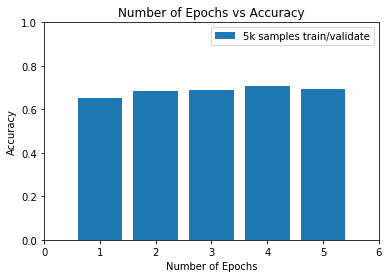

In [21]:
x = [1,2,3,4,5]
plt.bar(x, scores)

plt.xlim([0, len(x)+1])
plt.ylim([0, 1])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Number of Epochs vs Accuracy')
plt.legend(['5k samples train/validate'])

plt.show()

In [22]:
VOCAB_SIZE = 100
NUM_EPOCHS = 1
BATCH_SIZE = 64
EMBED_LENGTH = 32
DROPOUT_RATE = 0.2


# Read in the text data - this does not change so can/should be outside the function for speed
x_train_raw, y_train_raw = get_x_y(TRAIN_PATH)
x_test_raw, y_test_raw = get_x_y(TEST_PATH)

def prep_data(vocab_size=100, max_review_len=150):
    time_start = datetime.now()
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(x_train)
    
    # Fit our training data
    x_train_sequence = tokenizer.texts_to_sequences(x_train_raw)
    x_train_pad = pad_sequences(x_train_sequence, maxlen=max_review_len)

    # Fit our testing data
    x_test_sequence = tokenizer.texts_to_sequences(x_test_raw)
    x_test_pad = pad_sequences(x_test_sequence, maxlen=max_review_len)

    # Subset for testing
    x_train_pad_sub, y_train_sub = resample(x_train_pad, y_train_raw, replace=False, n_samples=5000, random_state=SEED)
    x_test_pad_sub, y_test_sub = resample(x_test_pad, y_test_raw, replace=False, n_samples=5000, random_state=SEED)

    print('Prepared data in ' + str(datetime.now() - time_start))
    return x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub

def basic_lstm_model(
    embedding_vector_length=32,
    dropout_rate=0.2, 
    vocab_size=100, 
    max_review_len=150,
    lstm_len=100
):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_len))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_len))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_and_evaluate_model(
    x_train=x_train_pad_sub,
    y_train=y_train_sub,
    x_test=x_train_pad_sub,
    y_test=y_test_sub,
    num_epochs=5,
    batch_size=32,
    max_review_len=100,
    embed_length=32,
    vocab_size=100,
    verbose=1
):
    time_start = datetime.now()
    model = basic_lstm_model(
        vocab_size=vocab_size,
        embedding_vector_length=embed_length,
        max_review_len=max_review_len
    )
    model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=verbose)
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]

In [23]:
max_review_lengths = [10, 25, 50, 100, 150, 200, 250]
scores = []

for max_review in max_review_lengths:
    print(max_review)
    x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
        vocab_size=100,
        max_review_len=max_review
    )
    
    scores.append(
        train_and_evaluate_model(
            x_train=x_train_pad_sub,
            y_train=y_train_sub,
            x_test=x_test_pad_sub,
            y_test=y_test_sub,
            num_epochs=2,
            max_review_len=max_review,
            verbose=0
        )
    )

10
Prepared data in 0:00:08.005396
5000/5000 [==============================] - 1s 279us/step
Accuracy: 62.46%
25
Prepared data in 0:00:08.085274
5000/5000 [==============================] - 2s 453us/step
Accuracy: 65.60%
50
Prepared data in 0:00:08.256901
5000/5000 [==============================] - 3s 667us/step
Accuracy: 69.28%
100
Prepared data in 0:00:08.212115
5000/5000 [==============================] - 5s 1ms/step
Accuracy: 70.74%
150
Prepared data in 0:00:08.202973
5000/5000 [==============================] - 7s 1ms/step
Accuracy: 68.58%
200
Prepared data in 0:00:08.463871
5000/5000 [==============================] - 9s 2ms/step
Accuracy: 66.98%
250
Prepared data in 0:00:08.250957
5000/5000 [==============================] - 11s 2ms/step
Accuracy: 68.26%


In [24]:
max_review_lengths = [10, 25, 50, 100, 150, 200, 250]
scores_250 = []

for max_review in max_review_lengths:
    print(max_review)
    x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
        vocab_size=250,
        max_review_len=max_review
    )
    
    scores_250.append(
        train_and_evaluate_model(
            x_train=x_train_pad_sub,
            y_train=y_train_sub,
            x_test=x_test_pad_sub,
            y_test=y_test_sub,
            num_epochs=2,
            max_review_len=max_review,
            vocab_size=250,
            verbose=0
        )
    )

10
Prepared data in 0:00:08.034902
5000/5000 [==============================] - 2s 321us/step
Accuracy: 64.18%
25
Prepared data in 0:00:08.178110
5000/5000 [==============================] - 2s 481us/step
Accuracy: 67.68%
50
Prepared data in 0:00:08.238789
5000/5000 [==============================] - 3s 685us/step
Accuracy: 70.60%
100
Prepared data in 0:00:08.601446
5000/5000 [==============================] - 5s 1ms/step
Accuracy: 74.62%
150
Prepared data in 0:00:08.312614
5000/5000 [==============================] - 7s 1ms/step
Accuracy: 74.56%
200
Prepared data in 0:00:08.305741
5000/5000 [==============================] - 9s 2ms/step
Accuracy: 70.46%
250
Prepared data in 0:00:08.709223
5000/5000 [==============================] - 11s 2ms/step
Accuracy: 74.96%


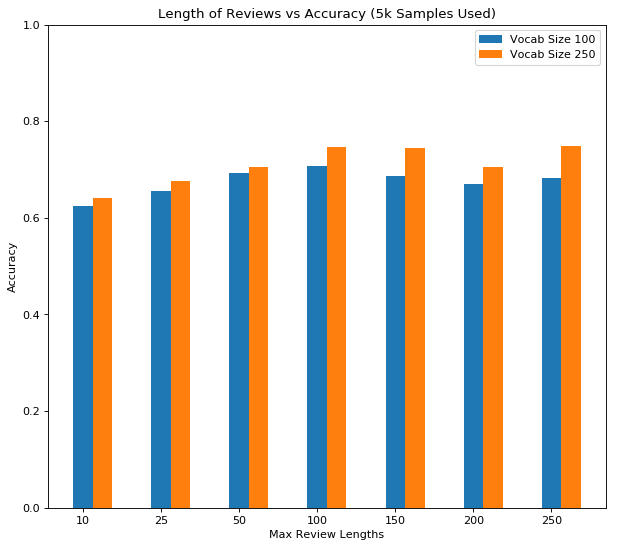

In [25]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')

x_range = np.arange(7)
width = 0.25

plt.bar(x_range, scores, width)
plt.bar(x_range + width, scores_250, width)

plt.xticks(x_range, max_review_lengths)
plt.ylim([0, 1])
plt.xlabel('Max Review Lengths')
plt.ylabel('Accuracy')
plt.title('Length of Reviews vs Accuracy (5k Samples Used)')
plt.legend(['Vocab Size 100', 'Vocab Size 250'])

plt.show()